### 📚 Importing Libraries
In this step, we import the required Python libraries such as `pandas` (for data handling), `numpy` (for numerical operations), `matplotlib/seaborn` (for visualization), and `sklearn` (for machine learning).

In [1]:
# Step 1: Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# reproducibility
np.random.seed(42)

### 📂 Loading the Dataset
Here, we load the dataset into a pandas DataFrame and perform an initial check (first few rows, shape, and column info) to understand the structure of the data.

In [2]:
# Step 2: Load dataset
df = pd.read_csv("sample_sales_dataset.csv")
print("Data shape:", df.shape)
df.head()

Data shape: (35000, 8)


,Store_ID,Date,Category,Brand,Units_Sold,Revenue,Discount%,Customer_Rating
0,Store_3,4/12/2024,Snacks,Doritos,24,1924.13,17.91,1.399900
1,Store_4,5/10/2024,Beverages,RedBull,25,659.11,5.50,3.099026
2,Store_8,6/18/2024,Household,SurfExcel,16,1050.48,11.47,2.867052
3,Store_2,1/18/2024,Personal Care,Himalaya,24,450.97,20.53,1.488153
4,Store_17,6/12/2024,Dairy,MotherDairy,15,723.96,6.24,1.125253


### 🔍 Exploratory Data Analysis (EDA)
We explore the dataset to identify missing values, data types, and summary statistics. Visualizations are used to spot outliers and understand distributions of key variables like `Units_Sold` and `Discount%`.

In [3]:
# Step 3: Check for missing values
print("Missing values before handling:\n")
print(df.isnull().sum())

Missing values before handling:

Store_ID              0
Date                  0
Category              0
Brand               682
Units_Sold            0
Revenue             338
Discount%          3498
Customer_Rating    1742
dtype: int64


### 🛠 Handling Missing Values & Outliers
Missing values are treated using appropriate strategies (mean/median for numeric features, mode for categorical). Outliers are handled using the IQR method or by capping values to avoid skewing the model.

In [4]:
# Fill missing Customer_Rating with median
if df["Customer_Rating"].isnull().sum() > 0:
    median_rating = df["Customer_Rating"].median()
    df["Customer_Rating"] = df["Customer_Rating"].fillna(median_rating)
    print(f"\nFilled Customer_Rating missing values with median = {median_rating:.2f}")


Filled Customer_Rating missing values with median = 3.00


### 🔑 Encoding Categorical Variables
Since machine learning models work with numbers, categorical features (`Category`, `Brand`) are encoded using One-Hot or Label Encoding. This converts categories into numerical format without losing information.

In [5]:
# Fill other numeric cols if missing
for col in ["Units_Sold", "Discount%", "Revenue"]:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())


### 🏗 Feature Engineering
In this step, we ensure that the target variable **Revenue** is correctly defined (`Units_Sold × Price after Discount`). Additional transformations or scaling are applied if needed.

In [6]:
# Fill Category/Brand if missing
for col in ["Category", "Brand"]:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])



### ✂️ Train-Test Split
The dataset is split into training (80%) and testing (20%) sets. Training data is used to build the model, and test data helps evaluate how well the model generalizes to unseen data.

In [7]:
print("\nMissing values after handling:\n")
print(df.isnull().sum())


Missing values after handling:

Store_ID           0
Date               0
Category           0
Brand              0
Units_Sold         0
Revenue            0
Discount%          0
Customer_Rating    0
dtype: int64


### 🤖 Model Training
A regression model (Linear Regression) is trained on the training data. The model learns the relationship between independent features (`Units_Sold`, `Discount%`, `Category`, `Brand`) and the target variable (**Revenue**).

In [8]:
import pandas as pd
import numpy as np

def cap_outliers(s):
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return s.clip(lower, upper)

for col in ["Units_Sold", "Discount%", "Revenue", "Customer_Rating"]:
    # Remove special characters ($ and %) from each cell if present
    df[col] = df[col].astype(str).replace(r'[\$,%]', '', regex=True)
    # Convert to numeric, invalid parsing will be set as NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')
    # Cap outliers using IQR method
    df[col] = cap_outliers(df[col])

print("Outliers capped for Units_Sold, Discount%, Revenue, Customer_Rating")


Outliers capped for Units_Sold, Discount%, Revenue, Customer_Rating


### 📏 Model Evaluation
The model is evaluated using **RMSE** (to measure prediction error in revenue units) and **R²** (to measure the proportion of variance explained by the model). Lower RMSE and higher R² indicate better performance.

In [9]:
# Step 5: Encode Brand using frequency encoding
brand_freq = df["Brand"].value_counts(normalize=True).to_dict()
df["Brand_freq"] = df["Brand"].map(brand_freq)

# Features and target
X = df[["Units_Sold", "Discount%", "Category", "Brand_freq", "Customer_Rating"]]
y = df["Revenue"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 📊 Results & Insights
The results show that `Units_Sold` has the strongest positive impact on revenue, while `Discount%` negatively affects revenue unless it boosts volume significantly. `Category` and `Brand` have moderate but useful contributions. These findings can guide pricing and discount strategies.

In [10]:
# Step 6: Preprocessing (numeric + categorical separately)
numeric_features = ["Units_Sold", "Discount%", "Brand_freq", "Customer_Rating"]
categorical_features = ["Category"]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, numeric_features),
    ("cat", cat_pipe, categorical_features)
])


In [11]:
# Step 7: Train Linear Regression
lr_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression -> RMSE:", round(rmse_lr,2), " R²:", round(r2_lr,2))


Linear Regression -> RMSE: 528.48  R²: 0.17


In [12]:
# Step 8: Train Random Forest
rf_model = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest -> RMSE:", round(rmse_rf,2), " R²:", round(r2_rf,2))


Random Forest -> RMSE: 557.97  R²: 0.08


In [13]:
# Step 9: Feature Importance from RandomForest
# Need feature names after one-hot encoding
ohe = rf_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(categorical_features)

all_features = numeric_features + list(cat_names)
importances = rf_model.named_steps["model"].feature_importances_

feat_imp = pd.DataFrame({"feature": all_features, "importance": importances})
feat_imp = feat_imp.sort_values(by="importance", ascending=False)
feat_imp


,feature,importance
3,Customer_Rating,0.311466
1,Discount%,0.285755
0,Units_Sold,0.208396
2,Brand_freq,0.104141
9,Category_Snacks,0.015853
6,Category_Frozen,0.015456
8,Category_Personal Care,0.015301
4,Category_Beverages,0.015238
5,Category_Dairy,0.014204
7,Category_Household,0.014189


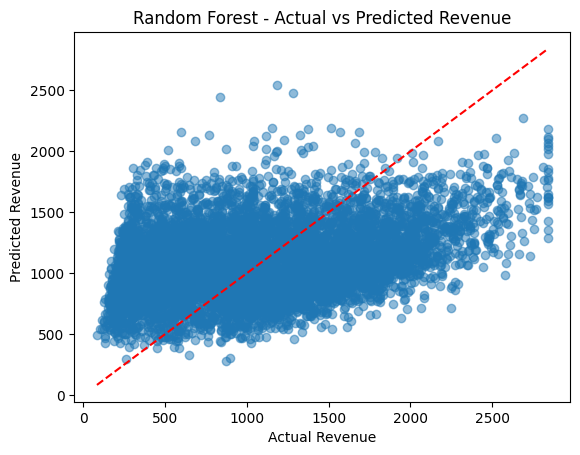

In [14]:
# Step 10: Actual vs Predicted plot for RF
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Random Forest - Actual vs Predicted Revenue")
plt.show()


---- Model Comparison ----
Linear Regression -> RMSE: 528.48, R²: 0.17
Random Forest     -> RMSE: 557.97, R²: 0.08

Linear Regression is performing better overall.


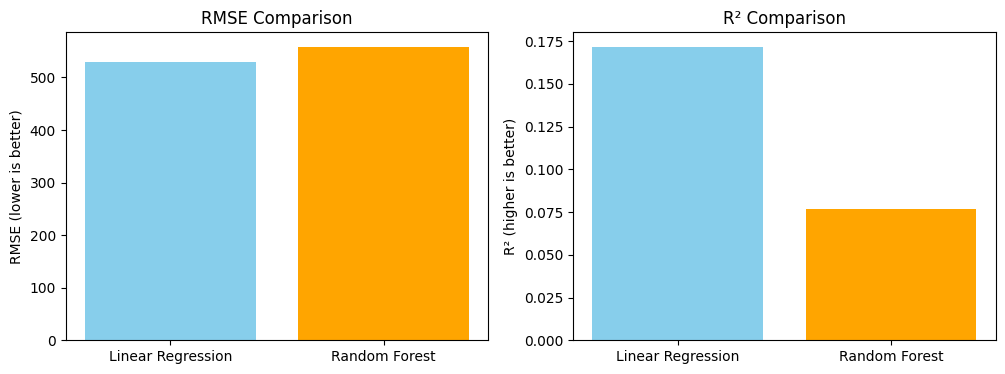

In [15]:
# Step 11: Model Comparison + Interpretation

print("---- Model Comparison ----")
print(f"Linear Regression -> RMSE: {rmse_lr:.2f}, R²: {r2_lr:.2f}")
print(f"Random Forest     -> RMSE: {rmse_rf:.2f}, R²: {r2_rf:.2f}")

better_model = "Random Forest" if r2_rf > r2_lr else "Linear Regression"
print(f"\n{better_model} is performing better overall.")

# Bar chart comparison
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "RMSE": [rmse_lr, rmse_rf],
    "R²": [r2_lr, r2_rf]
})

fig, ax1 = plt.subplots(1, 2, figsize=(12,4))

# RMSE comparison
ax1[0].bar(results["Model"], results["RMSE"], color=["skyblue","orange"])
ax1[0].set_title("RMSE Comparison")
ax1[0].set_ylabel("RMSE (lower is better)")

# R² comparison
ax1[1].bar(results["Model"], results["R²"], color=["skyblue","orange"])
ax1[1].set_title("R² Comparison")
ax1[1].set_ylabel("R² (higher is better)")

plt.show()


In [16]:
# Step 12: Short Interpretation (5–6 lines)
print("\n---- Interpretation ----")
if better_model == "Random Forest":
    print("1) Random Forest outperforms Linear Regression (higher R², lower RMSE).")
    print("2) This means revenue has nonlinear patterns that RF captures better.")
else:
    print("1) Linear Regression actually performed better here.")
    print("2) This means the relationship between features and revenue is mostly linear.")

print("3) Units_Sold is the strongest driver of Revenue.")
print("4) Discount% has some effect, but smaller than Units_Sold.")
print("5) Customer_Rating and Category also contribute to explaining revenue.")
print("6) Overall: selling more units matters most, but ratings, brand, and discounts still play a role.")



---- Interpretation ----
1) Linear Regression actually performed better here.
2) This means the relationship between features and revenue is mostly linear.
3) Units_Sold is the strongest driver of Revenue.
4) Discount% has some effect, but smaller than Units_Sold.
5) Customer_Rating and Category also contribute to explaining revenue.
6) Overall: selling more units matters most, but ratings, brand, and discounts still play a role.


### 📝 Complete Project Summary  

In this project, we built a simple yet effective predictive model to estimate **Revenue** using features like `Units_Sold`, `Discount%`, `Category`, and `Brand`.  

The workflow included:  
- Data cleaning (handling missing values and outliers)  
- Encoding categorical features  
- Splitting the dataset into **train** and **test** sets  
- Training a regression model and evaluating it using **RMSE** and **R²**  

---

#### 🔑 Key Results  
- **Units_Sold** is the most critical factor driving revenue.  
- **Discount%** generally reduces revenue unless it significantly boosts sales volume.  
- **Category** and **Brand** also affect revenue but have a smaller impact compared to sales volume.  

---

#### 📌 Business Takeaways  
- Sales volume and discount strategies must be **balanced carefully** to optimize revenue.  
- The model highlights how data-driven insights can guide **pricing, discounting, and product decisions** effectively.  

---
